In [2]:
import os
import gzip
from collections import defaultdict, Counter
import multiprocessing as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import *
import pysam
from pyBioInfo.IO.File import GffFile, BedFile
from pyBioInfo.Utils import ShiftLoader

In [3]:
chroms = ["chr%d" % c for c in range(1, 23)] + ["chrX", "chrY"]

chrom_lengths = dict()
path = "/home/chenzonggui/species/homo_sapiens/GRCh38.p13/GRCh38.canonical.genome.sizes"
with open(path) as f:
    for line in f:
        chrom, length = line.strip("\n").split("\t")
        chrom_lengths[chrom] = int(length)

path = "/home/chenzonggui/species/homo_sapiens/hg38/cytoBand.txt.gz"
bands = pd.read_csv(gzip.open(path, "rt"), sep="\t", header=None)
bands.columns = ["Chrom", "Start", "End", "Name", "Type"]
band_colors = {
    "stalk": "white",
    "acen": "red",
    "gvar": "white",
    "gneg": "white",
    "gpos25": "lightgrey",
    "gpos50": "grey",
    "gpos75": "black",
    "gpos100": "black"}

In [7]:
path1 = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/inversions.v2/inversions.bed.gz"
path2 = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round2/snvs.vcf.gz"
rows = []
with gzip.open(path1, "rt") as f, pysam.VariantFile(path2) as vcf:
    for line in f:
        row = line.strip("\n").split("\t")
        chrom, start, end = row[:3]
        start, end = int(start), int(end)
        count = len(list(vcf.fetch(chrom, start, end)))
        c, w, r = row[3].split(";")
        c = int(c)
        w = int(w)
        if c + w < 100:
            continue
        r = w / (c + w)
        if r >= 0.9:
            t = "HOM"
        elif r > 0.6:
            continue
        elif r >= 0.4:
            t = "HET"
        else:
            continue
        rows.append([chrom, start, end, c ,w, r, t, count])
invs = pd.DataFrame(rows, columns=["Chrom", "Start", "End", "Crick", "Watson", "Ratio", "Type", 'Count'])
invs.head()

,Chrom,Start,End,Crick,Watson,Ratio,Type,Count
0,chr1,258313,282091,85,105,0.552632,HET,17
1,chr1,13098399,13125506,53,49,0.480392,HET,1
2,chr1,13222539,13252302,121,121,0.500000,HET,30
3,chr1,16540721,16659274,1040,1219,0.539619,HET,150
4,chr1,108305351,108362655,143,141,0.496479,HET,11


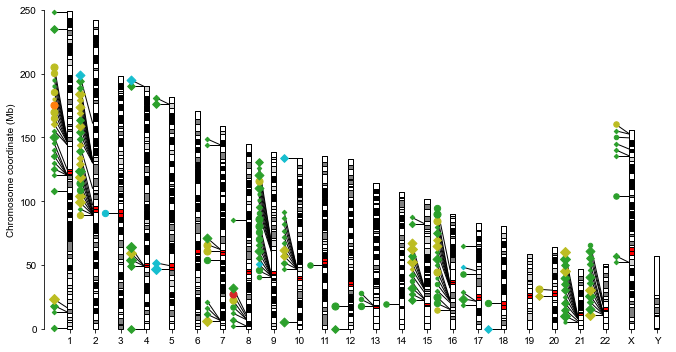

In [8]:
width = 0.2

plt.figure(figsize=(9.5, 5))

# chromosome
xs = []
ys = []
for i, chrom in enumerate(chroms):
    xs.append(i)
    ys.append(chrom_lengths[chrom])
plt.bar(xs, ys, edgecolor="black", color="none", width=width)

# band color
xs = []
ys = []
bottoms = []
colors = []
for i, chrom in enumerate(chroms):
    bands1 = bands[bands["Chrom"] == chrom]
    for start, end, t in bands1[["Start", "End", "Type"]].values:
        xs.append(i)
        ys.append(end - start)
        bottoms.append(start)
        colors.append(band_colors[t])
plt.bar(xs, ys, bottom=bottoms, color=colors, edgecolor="black", width=width, clip_on=False)

# inversion
def get_inversion_color(start, end):
    v = end - start
    if v >= 3e6: # 3M
        return "C3"
    elif v >= 1e6: # 1M
        return "C1"
    elif v >= 1e5: # 100k
        return "C8"
    elif v >= 1e4: # 10k
        return "C2"
    else:
        return "C9"
    
def get_marker_size(count):
    if count > 100:
        return 50
    elif count > 50:
        return 40
    elif count > 25:
        return 30
    elif count > 10:
        return 20
    else:
        return 10
    
for i, chrom in enumerate(chroms):
    lines = []
    min_y = None
    radius = 0.05e8
    invs1 = invs[invs["Chrom"] == chrom]
    for start, end, t, count in invs1[["Start", "End", "Type", "Count"]].values:
        x1 = i - width / 2
        x2 = i - 0.6
        y1 = (end + start) / 2
        if min_y:
            y2 = max(min_y + radius, y1)
        else:
            y2 = y1
        min_y = y2
        if t == "HOM":
            marker = "o"
        else:
            marker = "D"
        color = get_inversion_color(start, end)
        size = get_marker_size(count)
        plt.scatter(x2, y2, s=size, marker=marker, zorder=10, color=color, clip_on=False)
        plt.plot([x1, x2], [y1, y2], lw=1, color="black", zorder=9, clip_on=False)
    # break

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
vmax = max([chrom_lengths[chrom] for chrom in chroms])
plt.ylim(0, 2.5e8)
plt.ylabel("Chromosome coordinate (Mb)")
plt.yticks([0, 0.5e8, 1e8, 1.5e8, 2.0e8, 2.5e8], ["0", "50", "100", "150", "200", "250"])
plt.xticks(np.arange(len(chroms)), [c[3:] for c in chroms])
plt.xlim(-1, len(chroms) - 0.5)
plt.tight_layout()
# plt.savefig("figures/chromosome_inversions.pdf", dpi=300)

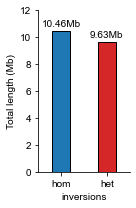

In [9]:
hom_length = 0
het_length = 0
chrom_length = 0
for chrom in chroms:
    chrom_length += chrom_lengths[chrom]
    invs1 = invs[invs["Chrom"] == chrom]
    for start, end, t in invs1[["Start", "End", "Type"]].values:
        v = end - start
        if t == "HOM":
            hom_length += v
        else:
            het_length += v
xs = [0, 1]
ys = np.array([hom_length, het_length]) / 1e6
plt.figure(figsize=(2, 3))
plt.bar(xs, ys, color=["C0", "C3"], edgecolor="black", width=0.4)
for x, y in zip(xs, ys):
    plt.text(x, y + 0.2, "%.2fMb" % y, va="bottom", ha="center")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(xs, ["hom", "het"], rotation=0)
plt.xlabel("inversions")
plt.ylabel("Total length (Mb)")
plt.ylim(0, 12)
plt.xlim(-0.5, 1.5)
# plt.yticks([0, 5, 10, 15])
plt.tight_layout()
# plt.savefig("figures/inversion_total_length.pdf", dpi=300)